In [1]:
#install package for technical indicators
!pip install ta 

In [2]:
#provided function in notes for pulling stock data
import io
import re
import requests

# The usual suspects
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt


# Fancy graphics
plt.style.use('seaborn')

# Getting Yahoo finance data (takes timestamp as seconds from epoch)
def getdata(tickers,start,end,frequency):
    OHLC = {}
    cookie = ''
    crumb = ''
    res = requests.get('https://finance.yahoo.com/quote/SPY/history')
    cookie = res.cookies['B']
    pattern = re.compile('.*"CrumbStore":\{"crumb":"(?P<crumb>[^"]+)"\}')
    for line in res.text.splitlines():
        m = pattern.match(line)
        if m is not None:
            crumb = m.groupdict()['crumb']
    for ticker in tickers:
        url_str = "https://query1.finance.yahoo.com/v7/finance/download/%s"
        url_str += "?period1=%s&period2=%s&interval=%s&events=history&crumb=%s"
        url = url_str % (ticker, start, end, frequency, crumb)
        res = requests.get(url, cookies={'B': cookie}).text
        OHLC[ticker] = pd.read_csv(io.StringIO(res), index_col=0,
                                   error_bad_lines=False).replace('null', np.nan).dropna()
        OHLC[ticker].index = pd.to_datetime(OHLC[ticker].index)
        OHLC[ticker] = OHLC[ticker].apply(pd.to_numeric)
    return OHLC

# A (lagged) technical indicator (Average True Range)
def ATR(df, n):
    df = df.reset_index()
    i = 0
    TR_l = [0]
    while i < df.index[-1]:
        TR = (max(df.loc[i + 1, 'High'], df.loc[i, 'Close']) -
              min(df.loc[i + 1, 'Low'], df.loc[i, 'Close']))
        TR_l.append(TR)
        i = i + 1
    return pd.Series(TR_l).ewm(span=n, min_periods=n).mean()

# Assets under consideration
tickers = ['MSFT']

data = None
while data is None:
    try:
        #timestamps as seconds from epoch
        data = getdata(tickers,'1388596314','1546362714','1d')
    except:
         pass

a = data['MSFT']
data = a
data.drop('Volume',axis=1,inplace=True)


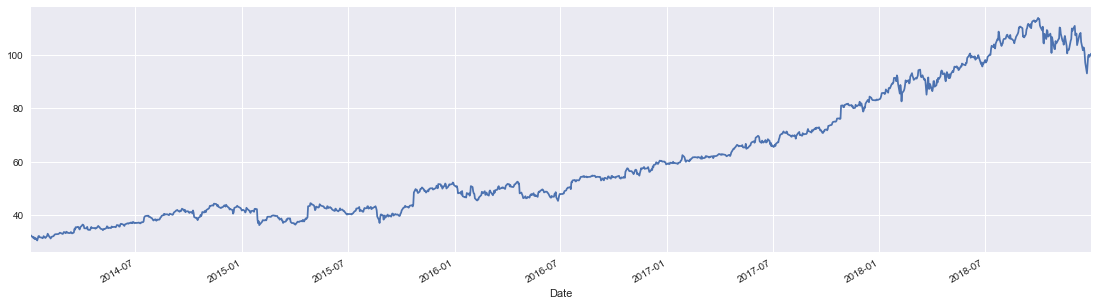

In [3]:
#plot adjusted close
data['Adj Close'].plot(figsize=(19,5))

In [4]:
#2 Technical indicators
import ta
# Relative Strength Indicator
a['RSI'] = ta.momentum.rsi(a['Adj Close'],3)

#Exponential Moving Average
a['EMA'] = ta.trend.ema_indicator(a['Adj Close'], 5)
a['EMA_Close'] = a['EMA'] - a['Adj Close']

#Moving Average Convergence Divergence
a['MACD'] = ta.trend.macd(a['Adj Close'], n_fast=12, n_slow=26, fillna=False)

#Average True Range
a['ATR'] = ta.volatility.average_true_range(a['High'], a['Low'], a['Adj Close'], n=14, fillna=False)

#Stochastic Oscillator
a['SR'] = ta.momentum.stoch(a['High'], a['Low'], a['Close'], n=14, fillna=False)

In [5]:
#3  returns and updown
a['Returns'] = a['Adj Close'].pct_change()
#Up Down indicator (+1 for positive return, -1 for negative return)
a['UpDoInd'] = np.sign(a['Returns'].dropna())

In [6]:
a.dropna(inplace=True)

In [7]:
#4 and 5, training and testing
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.metrics import confusion_matrix

# Lag the indicators to prevent look ahead bias
lag =1 
INDS = ["RSI","SR","EMA_Close","ATR","MACD"]
for i in INDS:
    a[i +'_lag1' ] = a[i].shift(1)

a.dropna(inplace=True)

#########
# Use the technical indicators to try and classify if T+1 will be + or - return
#########

X = a[["RSI_lag1" ,"SR_lag1","EMA_Close_lag1","ATR_lag1","MACD_lag1","UpDoInd"]]
start_test = pd.to_datetime('2017-10-01')
X_train = X[X.index<start_test]
X_test = X[X.index>start_test]
y_train = X_train['UpDoInd']
y_test = X_test['UpDoInd']


X_train = X_train.drop('UpDoInd',axis=1)
X_test = X_test.drop('UpDoInd',axis=1)
pred = pd.DataFrame(index=y_test.index)

hit rate: 0.7722929936305732 


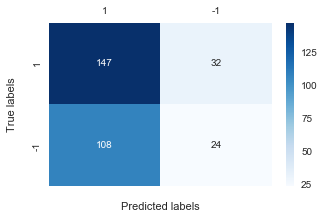

Accuracy: 0.5445859872611465


In [8]:
import seaborn as sns
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, auc, average_precision_score

# Quadratic Discriminant

qda = QDA()
qda.fit(X_train,y_train)
y_pred = qda.predict(X_test)
pred = (1.0 +(y_pred == y_test))/2.0
hit_rate= np.mean(pred)

print("hit rate: %s " %hit_rate)

cm = (confusion_matrix(y_test, y_pred,labels=[1,-1], sample_weight=None))

plt.figure(figsize=(5, 3))      # format the plot size
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap="Blues")
ax.set_xlabel('\nPredicted labels'); ax.set_ylabel('True labels\n')
ax.xaxis.tick_top()
ax.yaxis.set_ticklabels(['1', '-1'])
ax.xaxis.set_ticklabels(['1', '-1'])
plt.show()
acc = accuracy_score(y_test,y_pred)
print("Accuracy: %s" % acc)

Hit rate: 0.767515923566879


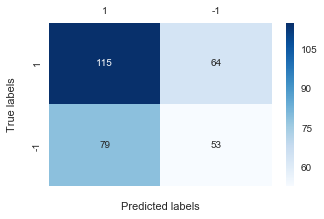

Accuracy: 0.535031847133758


In [9]:
# Support Vector Machine

from sklearn.svm import SVC
clf = SVC(gamma='auto')
clf.fit(X_train, y_train)
y_pred_svm = clf.predict(X_test)
pred = (1.0 +(y_pred_svm==y_test))/2.0 # 
hit_rate = np.mean(pred)
print("Hit rate: %s" %hit_rate)

cm = (confusion_matrix(y_test, y_pred_svm,labels=[1,-1], sample_weight=None))
#a.reshape((1, -1))
plt.figure(figsize=(5, 3))      # format the plot size
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap="Blues")
ax.set_xlabel('\nPredicted labels'); ax.set_ylabel('True labels\n')
ax.xaxis.tick_top()
ax.yaxis.set_ticklabels(['1', '-1'])
ax.xaxis.set_ticklabels(['1', '-1'])
plt.show()
acc = accuracy_score(y_test,y_pred_svm)
print("Accuracy: %s" %acc)

hit rate: 0.7993630573248408


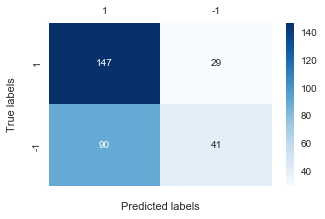

Accuracy: 0.5987261146496815


In [10]:
# Linear Discriminant

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

pred = pd.DataFrame(index=y_test.index)
lda = LDA()
lda.fit(X_train,y_train)
y_pred_lda = lda.predict(X_test)
pred_lda = (1.0 +(y_pred_lda==y_test))/2.0 
hit_rate = np.mean(pred_lda)
print("hit rate: %s" % hit_rate)

cm = (confusion_matrix(y_test, y_pred_lda,labels=[1,-1], sample_weight=None))
#a.reshape((1, -1))
plt.figure(figsize=(5, 3))      # format the plot size
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap="Blues")
ax.set_xlabel('\nPredicted labels'); ax.set_ylabel('True labels\n')
ax.xaxis.tick_top()
ax.yaxis.set_ticklabels(['1', '-1'])
ax.xaxis.set_ticklabels(['1', '-1'])
plt.show()
acc = accuracy_score(y_test,y_pred_lda)
print("Accuracy: %s" %acc)